# Project: CliniScan - Lung Abnormality Detection
# Dataset: VinDr-CXR (Chest X-rays)
# Model: YOLOv8
# Created by: Prarthana


# EDA

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import random

BASE = "/content/drive/MyDrive/CliniScan"
DATA_DIR = os.path.join(
    BASE,
    "1_Dataset",
    "vinbigdata-chest-xray-abnormalities-detection-512x512-jp2"
)
CSV_PATH = os.path.join(DATA_DIR, "train.csv")
IMAGE_DIR = os.path.join(DATA_DIR, "train")

EDA_DIR = os.path.join(BASE, "2_EDA")
os.makedirs(EDA_DIR, exist_ok=True)

print("CSV_PATH:", CSV_PATH)
print("IMAGE_DIR:", IMAGE_DIR)
print("EDA_DIR:", EDA_DIR)

CSV_PATH: /content/drive/MyDrive/CliniScan/1_Dataset/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/train.csv
IMAGE_DIR: /content/drive/MyDrive/CliniScan/1_Dataset/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/train
EDA_DIR: /content/drive/MyDrive/CliniScan/2_EDA


In [ ]:
df = pd.read_csv(CSV_PATH)
df.head()

,Unnamed: 0,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,170.09,301.37,406.89,401.32,2080,2336
3,3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,280.89,132.09,358.00,181.16,2304,2880
4,4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [ ]:
print("Total bounding-box rows in CSV:", len(df))
print("Total unique images:", df["image_id"].nunique())
print("Number of classes:", df["class_name"].nunique())
print("\nClass names:")
print(df["class_name"].unique())

Total bounding-box rows in CSV: 67914
Total unique images: 15000
Number of classes: 15

Class names:
['No finding' 'Cardiomegaly' 'Aortic enlargement' 'Pleural thickening'
 'ILD' 'Nodule/Mass' 'Pulmonary fibrosis' 'Lung Opacity' 'Atelectasis'
 'Other lesion' 'Infiltration' 'Pleural effusion' 'Calcification'
 'Consolidation' 'Pneumothorax']


Class counts:

class_name
No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: count, dtype: int64


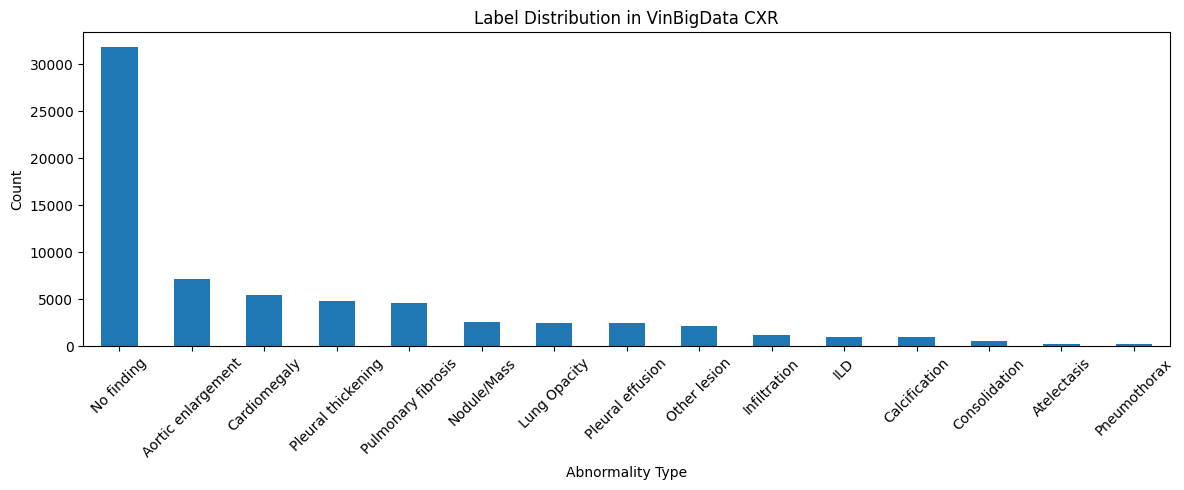

Most common class: No finding
Least common class: Pneumothorax
Imbalance ratio (max/min): 140.79


In [ ]:
class_counts = df["class_name"].value_counts()
print("Class counts:\n")
print(class_counts)
plt.figure(figsize=(12, 5))
class_counts.plot(kind="bar")
plt.title("Label Distribution in VinBigData CXR")
plt.xlabel("Abnormality Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "class_distribution.png"))
plt.show()

print("Most common class:", class_counts.idxmax())
print("Least common class:", class_counts.idxmin())
imbalance_ratio = class_counts.max() / class_counts.min()
print("Imbalance ratio (max/min):", round(imbalance_ratio, 2))

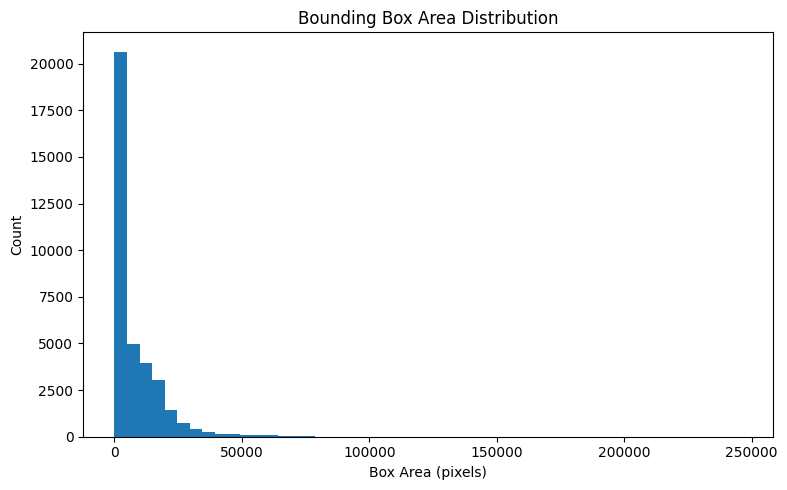

In [ ]:
df["box_width"] = df["x_max"] - df["x_min"]
df["box_height"] = df["y_max"] - df["y_min"]
df["box_area"] = df["box_width"] * df["box_height"]
df[["box_width", "box_height", "box_area"]].describe()
plt.figure(figsize=(8, 5))
plt.hist(df["box_area"], bins=50)
plt.title("Bounding Box Area Distribution")
plt.xlabel("Box Area (pixels)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "box_area_distribution.png"))
plt.show()


size_type
Large     32526
Medium    22404
Small     12984
Name: count, dtype: int64


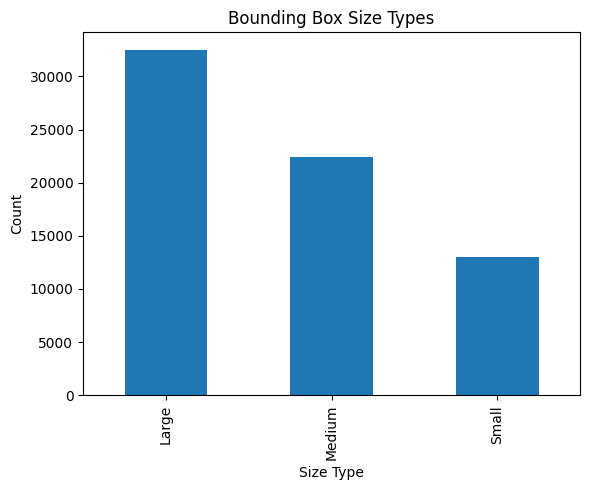

In [ ]:
def size_category(area):
    if area < 50 * 50:
        return "Small"
    elif area < 200 * 200:
        return "Medium"
    else:
        return "Large"

df["size_type"] = df["box_area"].apply(size_category)

print(df["size_type"].value_counts())
plt.figure(figsize=(6, 5))
df["size_type"].value_counts().plot(kind="bar")
plt.title("Bounding Box Size Types")
plt.xlabel("Size Type")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "box_size_categories.png"))
plt.show()


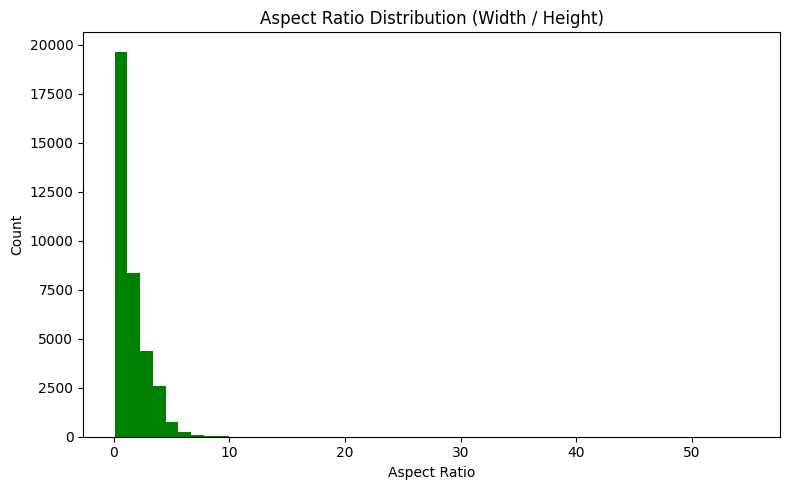

In [ ]:
df["aspect_ratio"] = df["box_width"] / df["box_height"]
df["aspect_ratio"].describe()
plt.figure(figsize=(8, 5))
plt.hist(df["aspect_ratio"], bins=50, color="green")
plt.title("Aspect Ratio Distribution (Width / Height)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "aspect_ratio_distribution.png"))
plt.show()

Random image file: e29fcb9b89f4ccf3e2caeb609b99fb5f.jp2
Image shape: (512, 512)


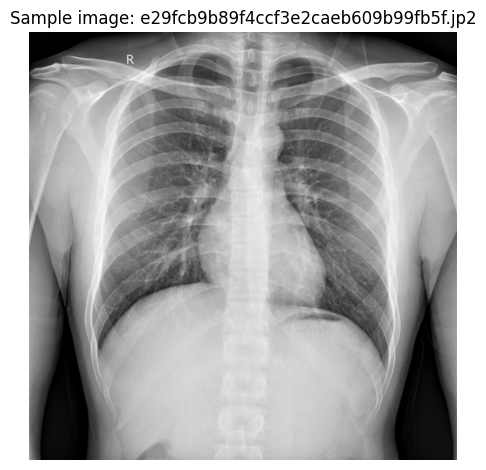

In [ ]:
img_name = random.choice(os.listdir(IMAGE_DIR))
img_path = os.path.join(IMAGE_DIR, img_name)
print("Random image file:", img_name)
img = Image.open(img_path)
img_array = np.array(img)

print("Image shape:", img_array.shape)
plt.imshow(img_array, cmap="gray")
plt.title(f"Sample image: {img_name}")
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "sample_image.png"))
plt.show()


In [ ]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print("Rows in TRAIN CSV:", len(train_df))
print("Rows in TEST CSV:", len(test_df))

Rows in TRAIN CSV: 67914
Rows in TEST CSV: 3000
